In [1]:
import gensim.models.doc2vec as d2v
import os
import pickle
import nltk
from pypet import progressbar
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# The Doc2Vec user comments analysis
This is an example of one of the models I trained on online user comments and the corresponding results.
Can we identify a publisher just by a comment made by a user?
This analysis involves 3 steps:

  1. Loading and data preparation
  2. Training or loading a Doc2Vec model
  3. Training a linear ML classifier
  
You can find my corresponding talk about this model [on YouTube](https://www.youtube.com/watch?v=zFScws0mb7M).

# 1. Data Preparation

Loads pickled user comment data from disk. Unfortunately, I cannot publish the data (yet), because I am missing the publishers' permissions.

In [2]:
def load_files(folder):
    """Loads the pickled comments from disk. Unfortunately I cannot publish the 
    scraped data due to copyright problmes"""
    res = []
    for filename in os.listdir(folder):
        print(filename)
        if filename.endswith('.pckl'):
            with open(os.path.join(folder, filename), 'rb') as fh:
                res.append(pickle.load(fh))
    return res


zeit_lists = load_files('./zeit2/')
spon_lists = load_files('./spon/')
fc_lists = load_files('./fc2/')

zeit_db_2015_24.pckl
zeit_db_2015_37.pckl
zeit_db_2015_28.pckl
zeit_db_2015_06.pckl
zeit_db_2015_29.pckl
zeit_db_2015_16.pckl
zeit_db_2015_26.pckl
zeit_db_2015_15.pckl
zeit_db_2014_12.pckl
zeit_db_2015_13.pckl
zeit_db_2015_18.pckl
zeit_db_2016_01.pckl
zeit_db_2015_11.pckl
zeit_db_2015_39.pckl
zeit_db_2015_48.pckl
zeit_db_2015_50.pckl
zeit_db_2015_14.pckl
zeit_db_2015_08.pckl
zeit_db_2014_03.pckl
zeit_db_2015_40.pckl
zeit_db_2015_02.pckl
zeit_db_2015_35.pckl
zeit_db_2015_32.pckl
zeit_db_2015_10.pckl
zeit_db_2015_31.pckl
zeit_db_2015_44.pckl
zeit_db_2014_06.pckl
zeit_db_2015_34.pckl
zeit_db_2015_20.pckl
zeit_db_2014_05.pckl
zeit_db_2015_30.pckl
zeit_db_2015_12.pckl
zeit_db_2015_43.pckl
zeit_db_2015_09.pckl
zeit_db_2014_04.pckl
zeit_db_2015_27.pckl
zeit_db_2015_45.pckl
zeit_db_2015_17.pckl
zeit_db_2015_04.pckl
zeit_db_2015_03.pckl
zeit_db_2015_01.pckl
zeit_db_2015_41.pckl
zeit_db_2014_01.pckl
zeit_db_2014_02.pckl
zeit_db_2015_07.pckl
zeit_db_2014_10.pckl
zeit_db_2014_13.pckl
zeit_db_2014_

In [3]:
def concate_dicts(*llist_):
    """Converts data into dictionaries with a publisher key label"""
    articles = {}
    comments = {}
    for list_, key in llist_:
        for db_articles, db_comments in list_:
            for article in db_articles.values():
                article['publisher'] = key
            for comment in db_comments.values():
                comment['publisher'] = key
            articles.update(db_articles)
            comments.update(db_comments)
    return articles, comments


articles, comments = concate_dicts((zeit_lists, 'zeit'), (spon_lists, 'spon'), (fc_lists, 'focus'))
art_ids = list(articles.keys())
com_ids = list(comments.keys())
print(len(articles), len(comments))

11076 512750


In [4]:
def tokenize_body(comments):
    """Tokenizes the comments, tokens are lowercased"""
    tokens = {}
    for idx, com_id in enumerate(comments):
        body = comments[com_id]['body']
        tokenized = [x.lower() for x in nltk.word_tokenize(body, language='german')]
        tokens[com_id] = tokenized
        progressbar(idx, len(comments), reprint=False)
    return tokens
        
    
tokens = tokenize_body(comments)

[                    ]  0.0%
[==                  ] 10.0%, remaining: 0:11:12
[====                ] 20.0%, remaining: 0:09:44
[======              ] 30.0%, remaining: 0:08:29
[========            ] 40.0%, remaining: 0:07:15
[==========          ] 50.0%, remaining: 0:06:02
[============        ] 60.0%, remaining: 0:04:49
[==============      ] 70.0%, remaining: 0:03:37
[================    ] 80.0%, remaining: 0:02:24
[==================  ] 90.0%, remaining: 0:01:12
[====================]100.0%


In [5]:
def create_tagged_objects(tokens):
    """Converts tokens to gensim tagged documents"""
    tagged_docs = {}
    for idx, com_id in enumerate(tokens):
        tagged_doc = d2v.TaggedDocument(words=tokens[com_id], tags=[com_id])
        tagged_docs[com_id]= tagged_doc
        progressbar(idx, len(comments), percentage_step=5, reprint=False)
    return tagged_docs


tagged_docs = create_tagged_objects(tokens)

[                    ]  0.0%
[=                   ]  5.0%, remaining: 0:00:33
[==                  ] 10.0%, remaining: 0:00:17
[===                 ] 15.0%, remaining: 0:00:11
[====                ] 20.0%, remaining: 0:00:14
[=====               ] 25.0%, remaining: 0:00:11
[======              ] 30.0%, remaining: 0:00:09
[=======             ] 35.0%, remaining: 0:00:07
[========            ] 40.0%, remaining: 0:00:08
[=========           ] 45.0%, remaining: 0:00:07
[==========          ] 50.0%, remaining: 0:00:05
[===========         ] 55.0%, remaining: 0:00:04
[============        ] 60.0%, remaining: 0:00:04
[=============       ] 65.0%, remaining: 0:00:04
[==============      ] 70.0%, remaining: 0:00:03
[===============     ] 75.0%, remaining: 0:00:02
[================    ] 80.0%, remaining: 0:00:02
[=================   ] 85.0%, remaining: 0:00:01
[==================  ] 90.0%, remaining: 0:00:00
[=================== ] 95.0%, remaining: 0:00:00
[====================]100.0%


In [6]:
def make_inverted_index(tagged_docs):
    """Creates and inverted index to quickly find comments containing particular words"""
    inv_index = {}
    for idx, com_id in enumerate(tagged_docs):
        doc = tagged_docs[com_id]
        words = doc.words
        for word in words:
            index_dict = inv_index.setdefault(word, {})
            index_dict[com_id] = index_dict.get(com_id, 0) + 1
        progressbar(idx, len(tagged_docs), reprint=False)
    return inv_index


inv_index = make_inverted_index(tagged_docs)

[                    ]  0.0%
[==                  ] 10.0%, remaining: 0:00:38
[====                ] 20.0%, remaining: 0:00:34
[======              ] 30.0%, remaining: 0:00:30
[========            ] 40.0%, remaining: 0:00:26
[==========          ] 50.0%, remaining: 0:00:22
[============        ] 60.0%, remaining: 0:00:17
[==============      ] 70.0%, remaining: 0:00:13
[================    ] 80.0%, remaining: 0:00:08
[==================  ] 90.0%, remaining: 0:00:04
[====================]100.0%


In [7]:
from scipy.stats import chi2_contingency


def get_aggregation(dicitionary, what='publisher'):
    """Aggregates summary counts of publishers"""
    result_dict = {}
    count=0
    for com_id, item in dicitionary.items():
        which = item[what]
        result_dict[which] = result_dict.get(which, 0) + 1
        #progressbar(count, len(dicitionary))
        count += 1
    return result_dict


def get_word_count(word, index, comments, what='publisher'):
    """Computes a word count per publisher"""
    count_dict = index[word]
    result_count = {}
    for com_id, count in count_dict.items():
        which = comments[com_id][what]
        result_count[which] = result_count.get(which, np.array([0, 0])) + np.array([count, 1])
    return result_count


def get_norm_count(word, index, comments, norm, what='publisher'):
    """Returns a normalized count of a word per publisher
    
    Runs a chi squared test on publisher vs publisher basis.
    """
    tmp = get_word_count(word, index, comments, what)
    result = {}
    for what, counts in tmp.items():
        result[what] = {'frac': counts[1] / float(norm[what]) * 100,
                        'wordcount' : counts[0],
                        'doccount' : counts[1],
                        'total' : norm[what]}
    
    thekeys = list(result.keys())
    tests = {}
    for idx, what in enumerate(thekeys):
        for jdx, what2 in enumerate(thekeys):
            if jdx <= idx:
                continue
            values = [ [result[what]['doccount'], result[what]['total'] - result[what]['doccount']],
                       [result[what2]['doccount'], result[what2]['total'] - result[what2]['doccount']]]
            tests[what + ' vs ' + what2] = chi2_contingency(values)
                
            
    return result, tests


norm_dict = get_aggregation(comments)
norm_dict

{'focus': 53539, 'spon': 287760, 'zeit': 171451}

In [8]:
# How often is `einigkeit` found in user comments per publisher
get_norm_count('einigkeit', inv_index, comments, norm_dict)

({'focus': {'doccount': 28,
   'frac': 0.052298324585815945,
   'total': 53539,
   'wordcount': 29},
  'spon': {'doccount': 103,
   'frac': 0.035793716986377531,
   'total': 287760,
   'wordcount': 108},
  'zeit': {'doccount': 91,
   'frac': 0.053076389172416603,
   'total': 171451,
   'wordcount': 97}},
 {'spon vs focus': (2.7891102446565603,
   0.09490691027264718,
   1,
   array([[  1.10450250e+02,   2.87649550e+05],
          [  2.05497496e+01,   5.35184503e+04]])),
  'spon vs zeit': (7.1955524142938811,
   0.007308448905060101,
   1,
   array([[  1.21568168e+02,   2.87638432e+05],
          [  7.24318320e+01,   1.71378568e+05]])),
  'zeit vs focus': (0.0015452776489096641,
   0.96864321822578847,
   1,
   array([[  9.06825592e+01,   1.71360317e+05],
          [  2.83174408e+01,   5.35106826e+04]]))})

# 2. Training or Loading the Doc2Vec model

In [9]:
# loads a model from disk, uncomment to train anew
model = d2v.Doc2Vec.load('./zeit_spon_focus_380k_256dim_20epochs_5mincount_8window_5negative_1e4.net')

In [10]:
import random


def get_articles_by_publisher(articles):
    """Returns a nested dict with articles per publisher"""
    articles_by_publisher = {}
    for com_id, article in articles.items():
        publisher = article['publisher']
        publisher_dict = articles_by_publisher.setdefault(publisher, {})
        publisher_dict[com_id] = article
    return articles_by_publisher


def train_test(comments, articles, test_frac = 0.25, model=None):
    """Creates a train test split.
    
    Takes care that comments from the same article are either in the train or test split.
    This avoids data leakage from train to test.
    
    If model is given, recreates training and test set of the model.
    """
    training = {}
    testing = {}
    
    training_articles = set()
    testing_articles = set()
    
    if model is not None:
        print('Using model training set!')
    
    articles_by_publisher = get_articles_by_publisher(articles)
    for publisher, publisher_articles in articles_by_publisher.items():
        narticles = len(publisher_articles)
        up_to = int(narticles*test_frac)
        article_keys = list(publisher_articles.keys())
        random.shuffle(article_keys)
        testing_articles.update(article_keys[:up_to])
        training_articles.update(article_keys[up_to:])
    
    for com_id, comment in comments.items():
        title = comment['title']
        if model is None:
            if title in testing_articles:
                testing[com_id] = comment
            elif title in training_articles:
                training[com_id] = comment
            else:
                print(title)
                print(training_articles)
                raise ValueError('You shall not pass!')
        else:
            if com_id in model.docvecs:
                training[com_id] = comment
            else:
                testing[com_id] = comment
    return training, testing


def count_by_publisher(dictionary):
    """Counts comments per publisher"""
    pub_count = {}
    for comment in dictionary.values():
        publisher = comment['publisher']
        pub_count[publisher] = pub_count.setdefault(publisher, 0) + 1
    return pub_count


random.seed(42)
training, testing = train_test(comments, articles, model=model)
print('Trainig Size: ' + str(count_by_publisher(training)))
print('Test Size:' + str(count_by_publisher(testing)))
training_tagged_docs = [tagged_docs[com_id] for com_id in sorted(training.keys())]
print(len(training_tagged_docs))
print(training_tagged_docs[-3])

Using model training set!
Trainig Size: {'zeit': 126988, 'spon': 217206, 'focus': 38279}
Test Size:{'spon': 70554, 'zeit': 44463, 'focus': 15260}
382473
TaggedDocument(['meinen', 'sie', 'nicht', ',', '``', 'echte', 'helden', "''", 'wie', 'der', 'knippi', 'und', 'der', 'richie', 'hätten', 'das', 'auch', 'geschafft', ',', 'sei', 'es', 'als', 'vater', 'oder', 'als', 'sohn', '.', 'sie', 'können', 'eben', 'nicht', 'ausstehen', ',', 'dass', 'einer', 'hier', 'im', 'forum', 'nicht', 'in', 'der', 'gläsernen', 'und', 'gut', 'auswattierten', 'kugel', 'aufgewachsen', 'ist', '.'], ['postbit_8659565'])


In [11]:
if model is None:
    # Train the model if not loaded before
    model = d2v.Doc2Vec(alpha=0.05, min_alpha=0.05, size=256, 
                        window=8, min_count=5, workers=13, sample=1e-4,
                        negative=5)  # use fixed learning rate
    print('Building vocab')
    model.build_vocab(training_tagged_docs)
    print('Vocab length: ' + str(len(model.vocab)))
    epochs = 20
    factor = 0.8
    for epoch in range(epochs):
        # train epoch by epoch
        print('Training epoch %d' % epoch)
        progressbar(epoch, epochs, 2, reprint=False)
        random.shuffle(training_tagged_docs)
        model.train(training_tagged_docs)
        model.alpha *= factor  # decrease the learning rate
        model.min_alpha = model.alpha  # fix the learning rate, no decay
else:
    print('Using exisiting model')

Using exisiting model


In [12]:
len(model.vocab)

115450

In [13]:
# Uncomment to store newly trained model
#model.save('./zeit_spon_focus_380k_256dim_20epochs_5mincount_8window_5negative_1e4.net')
model.vector_size

256

## Analysis of Doc2Vec results

Let us check some similarities and arithmetic.

In [14]:
model.most_similar(['lügenpresse'])

[('gutmensch', 0.4010172486305237),
 ('neiddebatte', 0.38453322649002075),
 ('putin-versteher', 0.3686279058456421),
 ('satire', 0.36785396933555603),
 ('lüge', 0.36566394567489624),
 ('weltmacht', 0.3519711196422577),
 ('gutmenschen', 0.3464166820049286),
 ('mutti', 0.34194207191467285),
 ('überschrift', 0.34042584896087646),
 ('verschwörungstheorie', 0.33931589126586914)]

In [15]:
model.most_similar(['npd'])

[('cdu', 0.40688908100128174),
 ('cdu/csu', 0.3952762484550476),
 ('christen', 0.376493901014328),
 ('csu', 0.3707805275917053),
 ('grünen', 0.3656056225299835),
 ('nato', 0.35830050706863403),
 ('pkk', 0.35469287633895874),
 ('nsdap', 0.34872081875801086),
 ('fifa', 0.34840717911720276),
 ('presse', 0.3452194035053253)]

In [16]:
model.most_similar(['hitler', 'putin'])

[('erdogan', 0.5759029388427734),
 ('schäuble', 0.5241702795028687),
 ('gauck', 0.5103901028633118),
 ('seehofer', 0.5060887932777405),
 ('obama', 0.5047944784164429),
 ('draghi', 0.49869856238365173),
 ('wulff', 0.49585679173469543),
 ('sarrazin', 0.4903891086578369),
 ('assad', 0.4888860583305359),
 ('tsipras', 0.48171353340148926)]

In [17]:
model.most_similar(['brexit', 'griechenland'], ['england'])

[('schuldenschnitt', 0.368825763463974),
 ('crash', 0.3611461818218231),
 ('streik', 0.3528655767440796),
 ('grexit', 0.3483351767063141),
 ('blutvergießen', 0.33942756056785583),
 ('widerspruch', 0.33040809631347656),
 ('bvb', 0.3299483358860016),
 ('esc', 0.327178955078125),
 ('wolf', 0.3265976309776306),
 ('hsv', 0.32614874839782715)]

In [18]:
model.most_similar(['auto'])     

[('fahrzeug', 0.7256940603256226),
 ('kind', 0.6843705773353577),
 ('land', 0.6809075474739075),
 ('smartphone', 0.6666008830070496),
 ('haus', 0.6659786701202393),
 ('handy', 0.6579813957214355),
 ('studium', 0.6391932964324951),
 ('produkt', 0.6350514888763428),
 ('programm', 0.6342238783836365),
 ('geschäft', 0.6303771734237671)]

In [19]:
model.most_similar(['könig', 'frau'], ['mann'])

[('fr.', 0.608452320098877),
 ('angela', 0.5996636152267456),
 ('mama', 0.44601213932037354),
 ('hollande', 0.4266117215156555),
 ('thomas', 0.38444945216178894),
 ('heiße', 0.38386327028274536),
 ('wilhelm', 0.38384321331977844),
 ('heisse', 0.37442219257354736),
 ('andrea', 0.3742326498031616),
 ('gabriel', 0.3742227852344513)]

# 3. Linear Machine Learning Classifier

Let's see if we can predict the publisher based on a user comment.

In [20]:
import numpy as np
from scipy import linalg as la


def pca(data, dims_rescaled_data=2, evecs=None):
    """ Performs a principal component analysis """
    m, n = data.shape
    data = data.copy()
    data -= data.mean(axis=0)
    evals = None
    if evecs is None:
        R = np.cov(data, rowvar=False)
        evals, evecs = la.eigh(R)
        idx = np.argsort(evals)[::-1]
        evecs = evecs[:,idx]
        evals = evals[idx]
        evecs = evecs[:, :dims_rescaled_data]
    return np.dot(evecs.T, data.T).T, evals, evecs

In [21]:
import pandas as pd


def get_doc_vecs(com_ids, model):
    """ Returns the doc2vecs as array. 
    
    In case of training data, the vector is taken from the model's docvecs.
    Test document vectors are inferred using gradient descent.
    """
    dim = model.vector_size
    inputs = np.zeros((len(com_ids), dim))
    for kdx, com_id in enumerate(com_ids):
        try:
            inputs[kdx, :] = model.docvecs[com_id]
        except KeyError:
            # infer the test vector
            inputs[kdx, :] = model.infer_vector(tagged_docs[com_id].words, steps=8)
        progressbar(kdx, len(com_ids), reprint=False)
    return inputs


def comments_to_frame(comments, model):
    """Turns user comments into pandas data frame"""
    com_ids = np.array(sorted(comments.keys()))
    com_range = np.arange(len(com_ids))
    multi_index = pd.MultiIndex.from_arrays([com_ids, com_range])
    columns = list(range(model.vector_size)) + ['publisher', 'rating', 'article_id', 'author']
    data = {}
    docvecs = get_doc_vecs(com_ids, model)
    for col in columns:
        if isinstance(col, int):
            data[col] = docvecs[:, col]
        else:
            data[col] = []
    for com_id in com_ids:
        comment = comments[com_id]
        data['publisher'].append(comment['publisher'])
        data['rating'].append(comment.get('recommendations', np.NaN))
        data['article_id'].append(comment['title'].__hash__())
        data['author'].append(comment['author'])
    data_frame = pd.DataFrame(columns=columns, index=multi_index, data=data)
    return data_frame

training_frame = comments_to_frame(training, model)
testing_frame = comments_to_frame(testing, model)

[                    ]  0.0%
[==                  ] 10.0%, remaining: 0:00:05
[====                ] 20.0%, remaining: 0:00:04
[======              ] 30.0%, remaining: 0:00:03
[========            ] 40.0%, remaining: 0:00:03
[==========          ] 50.0%, remaining: 0:00:02
[============        ] 60.0%, remaining: 0:00:02
[==============      ] 70.0%, remaining: 0:00:01
[================    ] 80.0%, remaining: 0:00:01
[==================  ] 90.0%, remaining: 0:00:00
[====================]100.0%
[                    ]  0.0%
[==                  ] 10.0%, remaining: 0:05:06
[====                ] 20.0%, remaining: 0:04:31
[======              ] 30.0%, remaining: 0:03:42
[========            ] 40.0%, remaining: 0:03:07
[==========          ] 50.0%, remaining: 0:02:37
[============        ] 60.0%, remaining: 0:02:07
[==============      ] 70.0%, remaining: 0:01:36
[================    ] 80.0%, remaining: 0:01:04
[==================  ] 90.0%, remaining: 0:00:32
[====================]100.0%


In [22]:
pcadata, _, evecs = pca(training_frame[list(range(256))])
tepcadata, _, _ = pca(testing_frame[list(range(256))], evecs=evecs)

In [23]:
tepcadata.shape

(130277, 2)

### How difficult is the problem?

Can we identify well-separated classes via a PCA?

Nope, it's most likely a hard taks!

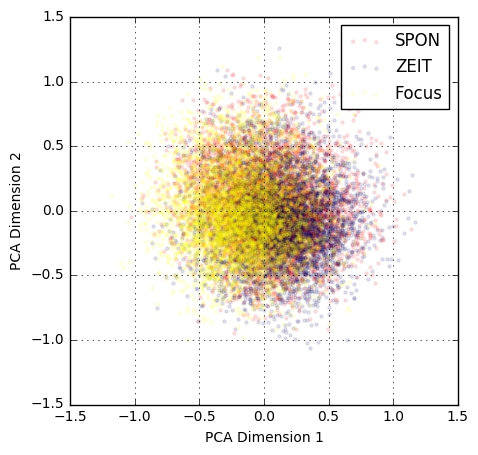

In [24]:
iszeit = (training_frame['publisher']=='zeit').values
isspon = (training_frame['publisher']=='spon').values
isfocus = (training_frame['publisher']=='focus').values

teiszeit = (testing_frame['publisher']=='zeit').values
teisspon = (testing_frame['publisher']=='spon').values
teisfocus = (testing_frame['publisher']=='focus').values

ssize = 5500  # Number of points to plot
plt.figure(figsize=(5,5))
plt.scatter(pcadata[isspon,0][:ssize],pcadata[isspon,1][:ssize], alpha=0.1, s=5, color='red', label='SPON')
plt.scatter(pcadata[iszeit,0][:ssize],pcadata[iszeit,1][:ssize], alpha=0.1, s=5, label='ZEIT')
plt.scatter(pcadata[isfocus,0][:ssize],pcadata[isfocus,1][:ssize], alpha=0.1, s=5, color='yellow', label='Focus')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.legend()
plt.grid()

In [44]:
def stratify_frame(data_frame, class_label='publisher', seed=42):
    """Returns stratified data frame with equal amount of comments per publisher"""
    all_classes = {}
    class_col = data_frame[class_label]
    for class_ in class_col:
        all_classes[class_] = all_classes.get(class_, 0) + 1
    min_val = float('inf')
    for class_, count in all_classes.items():
        if count < min_val:
            min_class = class_
            min_val = count
    
    frames = []
    for class_ in all_classes:
        new_frame = data_frame.loc[data_frame[class_label] == class_]
        if class_ != min_class:
            new_frame = new_frame.sample(n=min_val)
        frames.append(new_frame)
    return pd.concat(frames)

sf_training = stratify_frame(training_frame)
sf_testing = stratify_frame(testing_frame)

In [72]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, labels, title='Confusion matrix', cmap=plt.cm.Blues):
    """Plots the confusion matrix"""
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45, fontsize=14)
    plt.yticks(tick_marks, labels, fontsize=14)
    plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label', fontsize=15)
    plt.grid(True)

In [76]:
# let us train a linear classifier
from sklearn.linear_model import SGDClassifier

sX = sf_training[list(range(model.vector_size))].values
sy = sf_training['publisher'].values

sclf = SGDClassifier(penalty='elasticnet', loss='log', alpha=0.02, n_jobs=3)
sclf.fit(sX,sy)

SGDClassifier(alpha=0.02, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=5, n_jobs=3,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

### How is the classifier's perfomance?

Kinda ok, but as said, it is a very hard task indeed!

Training Score:0.559593162482
Testing Score: 0.470969855832
[[25885  6237  6157]
 [11430 14897 11952]
 [ 7532  7267 23480]]
[[ 4385  3639  7236]
 [ 1361  5077  8822]
 [  751  2410 12099]]


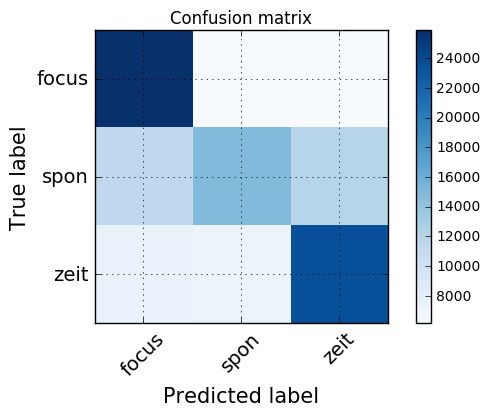

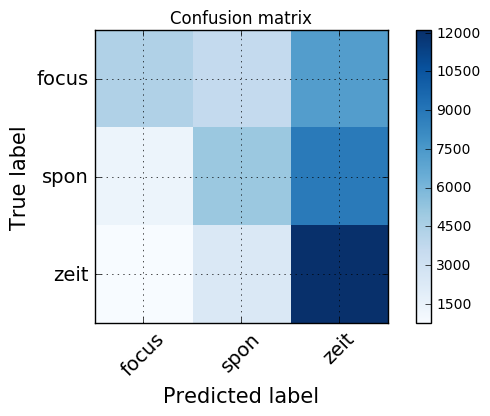

In [77]:
print('Training Score:' + str(sclf.score(sX, sy)))
tesX = sf_testing[list(range(model.vector_size))].values
tesy = sf_testing['publisher'].values
print('Testing Score: ' + str(sclf.score(tesX, tesy)))

labels = sclf.classes_
scm = confusion_matrix(sy, sclf.predict(sX), labels=labels)
stecm = confusion_matrix(tesy, sclf.predict(tesX), labels=labels)

print(scm)
print(stecm)

plot_confusion_matrix(scm, labels)
plt.figure()
plot_confusion_matrix(stecm, labels)

### Let us find the prototypical comments per publisher

These are just the comments in the training set that have the highest classification value of the classifier's decision function.

In [78]:
def print_com_ids(com_ids, comments, howmany=10, maxletter=256):
    """Prints an the first 256 characters of comment with a given `com_id`"""
    for irun in range(min(len(com_ids), howmany)):
        text = comments[com_ids[irun]]['body']
        if len(text) > maxletter:
            text = text[:maxletter] + '...'
        publisher = comments[com_ids[irun]]['publisher']
        rating = comments[com_ids[irun]].get('recommendations', 'N/A')
        print('\n---Comment %s from %s (rating %s) ---' % (com_ids[irun], publisher, str(rating)))
        print(text)


def find_k_best(clf_, frame, k=10, dims=256):
    """Find the k best matching comments per publisher"""
    com_ids = {}
    res_vals = {}
    classes = clf_.classes_
    data = frame[list(range(dims))].values
    try:
        index = frame.index.values
    except ValueError:
        index = []
        for irun in range(len(frame.index)):
            index.append(frame.index[irun])
    decisions = clf_.decision_function(data)
    for kdx, cls_ in enumerate(classes):
        decargs = np.argsort(decisions, 0)
        com_ids[cls_] = []
        res_vals[cls_] = []
        for krun in range(1, k+1):
            com_ids[cls_].append(index[decargs[-krun, kdx]][0])
            res_vals[cls_].append(decisions[decargs[-krun, kdx], :])
    return com_ids, res_vals
        
              
                      

In [79]:
best_com_ids, best_vals = find_k_best(sclf, sf_training)  

In [80]:
# the best classification values are
best_vals

{'focus': [array([ 0.67389282, -1.08930134, -1.30532411]),
  array([ 0.60979804, -0.97743507, -1.42604646]),
  array([ 0.53476268, -0.87085655, -1.22574588]),
  array([ 0.52759919, -0.99859831, -1.40937997]),
  array([ 0.52452468, -0.98092128, -1.15726704]),
  array([ 0.52356263, -0.90116416, -1.16999484]),
  array([ 0.52332239, -0.74398807, -1.40042701]),
  array([ 0.51160552, -0.89347114, -1.36981899]),
  array([ 0.50231504, -1.00847828, -1.12460275]),
  array([ 0.49809499, -0.92102766, -1.48242233])],
 'spon': [array([-1.5854564 , -0.02066652, -0.84890705]),
  array([-1.77652333, -0.05372939, -0.29132722]),
  array([-1.43188253, -0.06461331, -0.59356859]),
  array([-1.60069071, -0.08734061, -0.61239377]),
  array([-1.70918532, -0.13577106, -0.64204759]),
  array([-1.14915121, -0.1404845 , -0.70185351]),
  array([-1.05967491, -0.14374507, -1.05337679]),
  array([-1.10413472, -0.14544156, -0.92992469]),
  array([-1.92057455, -0.15403672, -0.51766651]),
  array([-1.47445796, -0.1598094

In [81]:
# the best comment ids
best_com_ids

{'focus': ['fc2384515747806803659',
  'fc-1488586985286617515',
  'fc6092971155995554073',
  'fc-6144842118117141000',
  'fc4779063311921099534',
  'fc-7020430312312956685',
  'postbit_27606958',
  'fc2537256418333258209',
  'fc-6907199175778523397',
  'fc-924506867720597566'],
 'spon': ['cid-4499545',
  'postbit_39491726',
  'postbit_40574192',
  'cid-5160001',
  'cid-4522325',
  'postbit_38624762',
  'postbit_33094580',
  'postbit_36027972',
  'postbit_15471345',
  'postbit_14862828'],
 'zeit': ['cid-4520538',
  'cid-5776689',
  'cid-5082365',
  'cid-4735762',
  'postbit_36896350',
  'cid-4753139',
  'cid-5089255',
  'cid-5712301',
  'cid-4804366',
  'cid-4546414']}

In [82]:
# let's print the prototypes
for class_, theids in best_com_ids.items():
    print('\n\nBEST FOR %s' % class_)
    print_com_ids(theids, comments, maxletter=600)



BEST FOR spon

---Comment cid-4499545 from zeit (rating 0) ---
Privatwirtschaftlich ungünstig
Das gesparte Geld landet dann aber nicht beim Hersteller des alten Toasters, weswegen dieser eben doch die Sollbruchstelle dort setzt, wo selbst der Fachmann nur mit der Flex hinkommt.
Reparatur ist für den Hersteller, der auf Wachstum setzt IMMER ungünstig, selbst wenn sie volkwirtschaftlich günstig ist. Wie auf dem Elektronikmarkt zu sehen ist es jedoch erfolgreicher kurzlebige Produkte herzustellen, die beim Austausch nach Defekt gleich den technischen Fortschritt mitmachen können. Technisch wäre es durchaus möglich Elektrogeräte oder sogar Autos modular zu ge...

---Comment postbit_39491726 from spon (rating N/A) ---
Ich meine mich zu erinnern, dass es im A6 BiTDI von ZF stammt.
Steht so auch hier:
http://www.motor-talk.de/blogs/autos-technik/datenblaetter-getriebeuebersetzungen-getriebe-allgemein-usw-t3089864.html

Zitat:
8-Gang ZF Tiptronic (8HP)
Überbrückungskupplung und 8 Fahrstufen.